### 01. Import libraries, env variables and get data from BigQuery

In [744]:
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
from pathlib import Path
import pandas as pd
import numpy as np
import os

In [745]:
# Import env variables from .env file

HOME_DIR = Path.cwd()
ENV_FILE = HOME_DIR / ".env"

if ENV_FILE.exists():
    load_dotenv(ENV_FILE)
else:
    raise

PROJECT_ID = os.getenv("GOOGLE_CLOUD_PROJECT_ID")
DATASET_ID = os.getenv("DATASET_NAME")

In [746]:
# # Import tables from BigQuery and save them as csv files locally

# client = bigquery.Client()
# table_names = ["events", "event_types"]

# # Helper function to get table from BigQuery
# def get_table_from_bigquery(table_name):
#     dataset_ref = bigquery.DatasetReference(PROJECT_ID, DATASET_ID)
#     table_ref = dataset_ref.table(table_name)
#     table = client.get_table(table_ref)
#     df = client.list_rows(table).to_dataframe()
#     return df

# # Loop through tables and save them as csv files
# for table in table_names:
#     df = get_table_from_bigquery(table)
#     file_path = HOME_DIR / f"data/{table}.csv"
#     df.to_csv(file_path, index=False)
#     print(f"Saved `{table}` table to {file_path}")

### 02. Events analysis

In [747]:
# Read csv files
events = pd.read_csv(HOME_DIR / "data/events.csv", parse_dates=["event_timestamp"]).drop("created_at", axis=1)
event_types = pd.read_csv(HOME_DIR / "data/event_types.csv")

# Combine tables to one dataframe 
df = (
    events.merge(event_types, how="left", on="event_type_id")
    # Remove useless event types and properly sort table
    .query("event_type_id != 4")
    .sort_values(["event_timestamp", "event_index"], ascending=[True, True])
)

# Create day column
df["day"] = df["event_timestamp"].dt.date

# Side peak column
df["team"] = np.where(df["event_type_id"] == 7, df["description"].str.split().str[3].str.replace('"', ""), np.nan)
# Forward fill values to identify team side for each event
df["team"] = df["team"].replace({"TERRORIST": "T"}).ffill()

# Calculate kills and deaths columns
weapon_mask = df["description"].str.split().str[-1].str.strip()
kill_mask = df["description"].str.split().str[-3].str.strip()

df["death"] = np.where(df["event_type_id"] == 2, 1, 0)
df["awp_death"] = np.where((df["event_type_id"] == 2) & (weapon_mask == "awp"), 1, 0)

df["kill"] = np.where(df["event_type_id"] == 5, 1, 0)
df["headshot_kill"] = np.where((df["event_type_id"] == 5) & (kill_mask == "headshot"), 1, 0)

df.head(10)

,event_timestamp,event_index,event_type_id,description,event,day,team,death,awp_death,kill,headshot_kill
18,2025-10-04 23:48:17,1,1,I connected to the server,Connect,2025-10-04,NaN,0,0,0,0
1451,2025-10-04 23:49:20,3,7,"I joined team ""TERRORIST"" (Террористы)",Team,2025-10-04,T,0,0,0,0
1184,2025-10-04 23:50:06,6,5,I killed Антон Рапира with ak47,Kill,2025-10-04,T,0,0,1,0
753,2025-10-04 23:50:20,8,5,I killed King_Kyt with a headshot from ak47,Kill,2025-10-04,T,0,0,1,1
1037,2025-10-04 23:50:21,11,5,I killed b2 with a headshot from ak47,Kill,2025-10-04,T,0,0,1,1
615,2025-10-04 23:50:21,12,5,I killed Anomaly with a headshot from ak47,Kill,2025-10-04,T,0,0,1,1
605,2025-10-04 23:51:30,17,5,I killed Anomaly with a headshot from ak47,Kill,2025-10-04,T,0,0,1,1
227,2025-10-04 23:51:50,20,2,VrK killed me with deagle,Death,2025-10-04,T,1,0,0,0
1038,2025-10-04 23:51:50,21,5,I killed b2 with a headshot from ak47,Kill,2025-10-04,T,0,0,1,1
1453,2025-10-04 23:52:56,25,7,"I joined team ""TERRORIST"" (Террористы)",Team,2025-10-04,T,0,0,0,0


In [748]:
# Assign game session groups for each event

def assign_game_sessions(col, start_value, end_values):
    game_session = 0
    # Track the current active session during iteration
    active_group = None 
    game_sessions_col = len(col) * [np.nan]

    for i, event in enumerate(col):
        # Check if event is start of new session
        if event == start_value:
            # Start new session only if there is no active session
            if active_group is None:
                game_session += 1
                active_group = game_session

            game_sessions_col[i] = active_group

        # End of current session if event "Connect" or "Disconnect"
        elif event in end_values:
            game_sessions_col[i] = active_group
            active_group = None

        else:
            game_sessions_col[i] = active_group

    return game_sessions_col

df["game_session"] = assign_game_sessions(df["event_type_id"], start_value=7, end_values=[1, 3])
df["game_session"] = df["game_session"].astype("Int64")

In [749]:
# Remove outliers where time difference between disconnect from the server and previous event too high

# Create ranking column
df["rnk"] = df.sort_values(["event_timestamp", "event_index"], ascending=[False, False]).groupby("game_session").cumcount() + 1

# Get time difference for 2 the most recent events in each game session
game_sessions = df.query("rnk <= 2").copy()
game_sessions["previous_event"] = game_sessions.groupby("game_session")["event_timestamp"].shift(1)
game_sessions["time_diff"] = (game_sessions["event_timestamp"] - game_sessions["previous_event"]).dt.total_seconds()

# Filter dataframe
outlier_event_indexes = game_sessions.query("rnk == 1 & time_diff > 300")["event_index"].tolist()
filtered_df = df[~df["event_index"].isin(outlier_event_indexes)]

print(f"Removed {len(outlier_event_indexes)} outlier events:", outlier_event_indexes)

Removed 3 outlier events: [1864, 1981, 2824]


In [779]:
# Calculate necessary metrics and get final result

# Session duration calculation
sessions_duration = filtered_df.groupby("game_session").agg(session_start=("event_timestamp", "min"), session_end=("event_timestamp", "max")).reset_index()
sessions_duration["duration_in_minutes"] = round((sessions_duration["session_end"] - sessions_duration["session_start"]).dt.total_seconds() / 60, 2)

# Kills and deaths aggregations
metrics = (
    filtered_df.groupby(["day", "game_session", "team"])
    .agg( deaths=("death", "sum"), awp_deaths=("awp_death", "sum"), kills=("kill", "sum"), headshot_kills=("headshot_kill", "sum"),)
    .reset_index()
)

# Join tables together
result = metrics.merge(sessions_duration, how="left", on="game_session").query("duration_in_minutes > 1")
result.head(10)

,day,game_session,team,deaths,awp_deaths,kills,headshot_kills,session_start,session_end,duration_in_minutes
0,2025-10-04,1,T,1,0,12,10,2025-10-04 23:49:20,2025-10-04 23:55:44,6.40
1,2025-10-08,2,CT,6,2,2,2,2025-10-08 22:31:53,2025-10-08 22:37:40,5.78
2,2025-10-12,3,CT,1,0,1,0,2025-10-12 15:25:39,2025-10-12 15:32:12,6.55
3,2025-10-12,3,T,5,2,2,2,2025-10-12 15:25:39,2025-10-12 15:32:12,6.55
4,2025-10-12,4,CT,2,0,6,3,2025-10-12 23:15:35,2025-10-12 23:52:37,37.03
5,2025-10-12,4,T,31,4,48,35,2025-10-12 23:15:35,2025-10-12 23:52:37,37.03
6,2025-10-15,5,CT,22,9,45,37,2025-10-15 22:45:37,2025-10-15 23:48:48,63.18
7,2025-10-15,5,T,27,14,38,31,2025-10-15 22:45:37,2025-10-15 23:48:48,63.18
8,2025-10-15,6,CT,0,0,0,0,2025-10-15 23:52:46,2025-10-16 00:32:27,39.68
9,2025-10-15,6,T,6,2,7,6,2025-10-15 23:52:46,2025-10-16 00:32:27,39.68


### 03. Visualizations

In [803]:
result.head()

,day,game_session,team,deaths,awp_deaths,kills,headshot_kills,session_start,session_end,duration_in_minutes
0,2025-10-04,1,T,1,0,12,10,2025-10-04 23:49:20,2025-10-04 23:55:44,6.40
1,2025-10-08,2,CT,6,2,2,2,2025-10-08 22:31:53,2025-10-08 22:37:40,5.78
2,2025-10-12,3,CT,1,0,1,0,2025-10-12 15:25:39,2025-10-12 15:32:12,6.55
3,2025-10-12,3,T,5,2,2,2,2025-10-12 15:25:39,2025-10-12 15:32:12,6.55
4,2025-10-12,4,CT,2,0,6,3,2025-10-12 23:15:35,2025-10-12 23:52:37,37.03


In [804]:
sns.set_style("darkgrid")

In [806]:
awp_deaths_pct = result["awp_deaths"].sum() / result["deaths"].sum() * 100
print(f"AWP deaths pct: {awp_deaths_pct:.2f}%")

AWP deaths pct: 36.96%


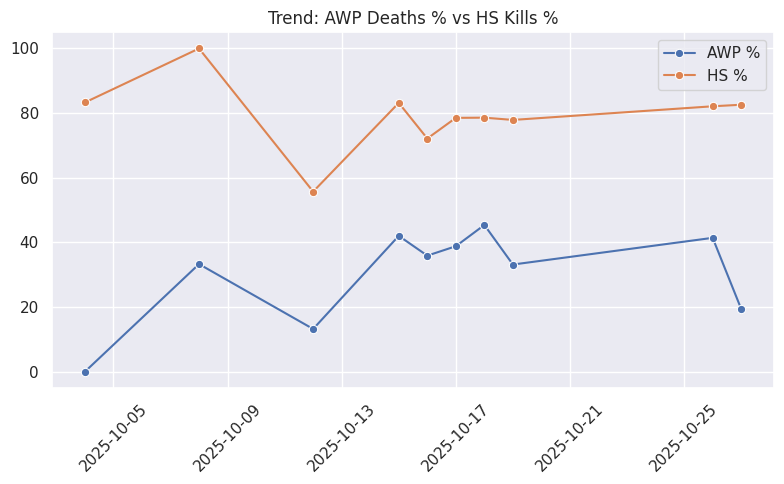

In [756]:
# timeline trend
trends_table = result.groupby("day").agg(avg_awp_deaths_pct=("awp_deaths_pct", "mean"), avg_hs_pct=("hs_pct", "mean")).reset_index()

trends_table

plt.figure(figsize=(8, 5))

sns.lineplot(data=trends_table, x="day", y="avg_awp_deaths_pct", label="AWP %", marker="o")
sns.lineplot(data=trends_table, x="day", y="avg_hs_pct", label="HS %", marker="o")

plt.xticks(rotation=45)
plt.xlabel("") 
plt.ylabel("")
plt.title("Trend: AWP Deaths % vs HS Kills %")
plt.tight_layout()
plt.show()

In [757]:
# Team side analysis

team_side = result.groupby("team")["awp_deaths_pct"].mean().reset_index()
team_side

,team,awp_deaths_pct
0,CT,33.616667
1,T,32.918182


In [758]:
result.dtypes

day                            object
game_session                    Int64
team                           object
deaths                          int64
awp_deaths                      int64
kills                           int64
headshot_kills                  int64
awp_deaths_pct                float64
hs_pct                        float64
session_start          datetime64[ns]
session_end            datetime64[ns]
duration_in_minutes           float64
dtype: object